# Part 1: Problem Definition
This problem is to explore building trading strategies using CCASS data. We collected public data of custodian distribution for each Hong Kong stocks listed on the main board and stored the data in AWS S3 bucket. We can use boto3 library to access the data. The sample data is also stored in dropbox for easier access. We then built some filters on stocks with the CCASS data and list out the trading days that meet certain requirements.

Then, we tried to design an automated trading solution for single stock using deep reinforcement learning. 

# Part 2: Install packages and libraries

In [32]:
# Install packages
!pip install backtrader

#Install libraries
import pandas as pd
import os
import backtrader as bt
import datetime as datetime
import yfinance as yf
import backtrader.analyzers as btanalyzers
from backtrader.analyzers import SharpeRatio
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", message="DataFrame is highly fragmented.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Part 3: Design Backtrader environment

We will use backtrader for backtesting where we need to set up a Cerebro engine.

In [33]:
# Create a Strategy class
class MyStrategy(bt.Strategy):

    params = (
            ('exitbars',10), ## Assume hold the stock for 10 days after buy
        )    
    
    def __init__(self):
        self.backtest_list = backtest_list
        self.bar_executed = {key: 0 for key in range(len(self.backtest_list))}
        # We want to check if the current price of the stock is at a relativelt low level. If it is at the bottom, we might want to wait rather than buy.
        self.lowest_lows = {}
        for i, d in enumerate(self.datas):
            self.lowest_lows[i] = bt.indicators.Lowest(self.datas[i],period = low_history_days)
        
    
    def next(self):
        i=0
        for ticker, backtest_dates in self.backtest_list:
            cur_date = self.data.datetime.date()
            
            #check if today dates is in backtest dates
            if cur_date in backtest_dates:
                
                # Criteria 1 for stock price: larger than recent lows
                Criteria1 = (self.datas[i].close[0]>self.lowest_lows[i][0])
                
                if Criteria1:
                    self.log("Buy Create {}".format(self.datas[i]))
                    
                    # Calculate how many shares we can buy with certain percentage of cash in portfolio 
                    cash = self.broker.get_cash()
                    target_value = size_stake * cash 
                    price = self.datas[i].close[0]
                    size = int(target_value / price)
                    
                    self.buy(self.datas[i], size=size)
                    self.bar_executed[i] = len(self)
            
            
            if self.bar_executed[i]>0:
                # hold for "exit_bar" number of days and sell
                if len(self) >= (self.bar_executed[i] +self.params.exitbars):
                    self.log("Sell create {}".format(self.datas[i]))
                    self.close(self.datas[i])
                    self.bar_executed[i]=0
                    
            i+=1
            
            
    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print("{} {}".format(dt.isoformat(),txt))


        

def backtesting(backtest_list, start_date, end_date, init_cash, broker_com, MyStrategy):
    %matplotlib inline
    cerebro = bt.Cerebro()

    
    if backtest_list:
        for ticker,backtest_dates in backtest_list:
            try:
                temp = bt.feeds.PandasData(dataname=yf.download(str(int(ticker)).zfill(4)+'.HK', start_date, end_date, auto_adjust=True))
            
                temp.plotinfo.plot = False
                cerebro.adddata(temp)
            except Exception as e:
                error_msg = str(e)
                if 'Failed download' in error_msg:
                    backtest_list.remove([ticker,backtest_dates])
        
    cerebro.addsizer(bt.sizers.SizerFix, stake=100)
    
    cerebro.addstrategy(MyStrategy)
    cerebro.addanalyzer(SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)
    cerebro.broker.setcash(init_cash)
    cerebro.broker.setcommission(commission = broker_com)
    print("Start portfolio {}".format(cerebro.broker.getvalue()))
    thestrats = cerebro.run() #stdstats=False, runonce=False
    print("FInal Portfolio {}".format(cerebro.broker.getvalue()))
    thestrat = thestrats[0]
    #print(thestrat.analyzers.mysharpe.get_analysis())
    for each in thestrat.analyzers:
        each.print()
    plt.figure() #.set_figheight(2000)    
    cerebro.plot() #lot=False  #if error, need install matplotlib==3.2.2
    plt.show()

    return True

# We will create a dataframe with changes of the custodian distribution for each stock. Here we will define some criteria for filtering some stocks for further testing.    
def stock_filter(df, broker_holding_change, concentration_crit):
    broker_change = pd.DataFrame()
    for column in df.columns[0:-3]:
        broker_change['{}_change'.format(column)]= df[column].diff().fillna(0)
    
    # Criteria 1: check if each broker got a certain percentage change in its holdings 
    Criteria1 = (abs(broker_change) > broker_holding_change)
    df["Criteria1"] = Criteria1.any(axis='columns')
    
    # Criteria 2: check if retail brokers got a decrease in their holdings   
    df['Criteria2'] = ((df['Retail'].diff())<df['unknown'].diff())

    # Criteria 3: check concentration - if top 5 brokers occupy a certain percentage of shares in CCASS
    df['Criteria3'] = df.select_dtypes('number').apply(lambda r: r.nlargest(5).sum(), axis=1)>concentration_crit
       
    # Check if all criteria are met
    df['Fullfilment'] = df[['Criteria1','Criteria2','Criteria3']].all(axis='columns')
 
    
    return (df['Fullfilment'])    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part 4: Preprocess data and filter stocks

In [34]:
# Set some hyper-parameters here
broker_holding_change = 0.05 # For Criteria 1: check if broker change more than a certain percentage in ccass
concentration_crit = 0.5 # For Criteria 3: check if concentration in ccass is higher than this threshold
low_history_days = 40 # Check if current price is higher than 50 low
start_date=datetime.date(2021, 5, 27)
end_date = datetime.date(2022,5,27)  
broker_com = 0.001 
init_cash = 1000000
size_stake = 0.2 # Assume we use 20% cash to buy a new stock

###############

In [35]:

# Download the sample data csv from dropbox.
ccass_df = pd.read_csv("https://www.dropbox.com/s/4lupbw0pkfs1kgv/out2.csv?dl=1", parse_dates= ["record_date"])

# Get the classification of the brokers, either Retail, Institution, or unknown
#broker_type = pd.read_csv(os.getcwd()+'/data/brokers.csv')
broker_type = pd.read_csv("https://www.dropbox.com/s/zm15cfj2l7e9kmq/broker.csv?dl=1")

# convert the date_time column to datetime object
ccass_df['record_date'] = pd.to_datetime(ccass_df['record_date'])
ccass_df['record_date'] = ccass_df['record_date'].dt.date
ccass_df = pd.merge(ccass_df, broker_type, how="left", on=["participant_name"]).fillna("unknown")
# Obtain a list of unique stock codes in the data.
stock_list = ccass_df['stock_code'].unique()
##########

# Create a list for backtesting
backtest_list=[]

for stock in stock_list:
    # Loop the stock list in the database, call the stock_filter function to check the dates that satisfy the requirements.
    df = ccass_df[ccass_df['stock_code']==stock]
    df = df.drop_duplicates(subset = ['record_date','participant_name'])
    screen_input = df.pivot(index = 'record_date', columns = 'participant_name', values = 'percent').fillna(0)
    pivot_bytype = df.pivot_table(index='record_date',columns='participant_type',values='percent',aggfunc='sum').fillna(0)
    screen_input = screen_input.join(pivot_bytype).fillna(0)
    filter_result = stock_filter(screen_input, broker_holding_change, concentration_crit)
    if any(filter_result):
        # Record the stock and dates that satisfy the requirements.
        backtest_list.append([stock, filter_result.index[filter_result].tolist()])
    

# Part 5: Backtesting

In [36]:
backtest_list.remove([2352, [datetime.date(2022, 5, 27)]])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
backtest_list

[[59,
  [datetime.date(2022, 4, 26),
   datetime.date(2022, 5, 7),
   datetime.date(2022, 5, 13)]],
 [205, [datetime.date(2022, 5, 7)]],
 [343, [datetime.date(2022, 4, 22)]],
 [362, [datetime.date(2022, 5, 27)]],
 [471, [datetime.date(2022, 5, 27)]],
 [503, [datetime.date(2022, 4, 21)]],
 [572, [datetime.date(2022, 4, 22), datetime.date(2022, 5, 27)]],
 [616, [datetime.date(2022, 4, 21)]],
 [673, [datetime.date(2022, 5, 10)]],
 [690, [datetime.date(2022, 5, 27)]],
 [767, [datetime.date(2022, 5, 7)]],
 [894, [datetime.date(2022, 5, 16)]],
 [936, [datetime.date(2022, 5, 27)]],
 [948, [datetime.date(2022, 5, 11)]],
 [994, [datetime.date(2022, 5, 13)]],
 [1028, [datetime.date(2022, 5, 27)]],
 [1059, [datetime.date(2022, 5, 27)]],
 [1216, [datetime.date(2022, 5, 10)]],
 [1247, [datetime.date(2022, 5, 12)]],
 [1259, [datetime.date(2022, 5, 12)]],
 [1281, [datetime.date(2022, 4, 26)]],
 [1282, [datetime.date(2022, 5, 16)]],
 [1400, [datetime.date(2022, 5, 27)]],
 [1495, [datetime.date(2022, 4

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<IPython.core.display.Javascript object>

True

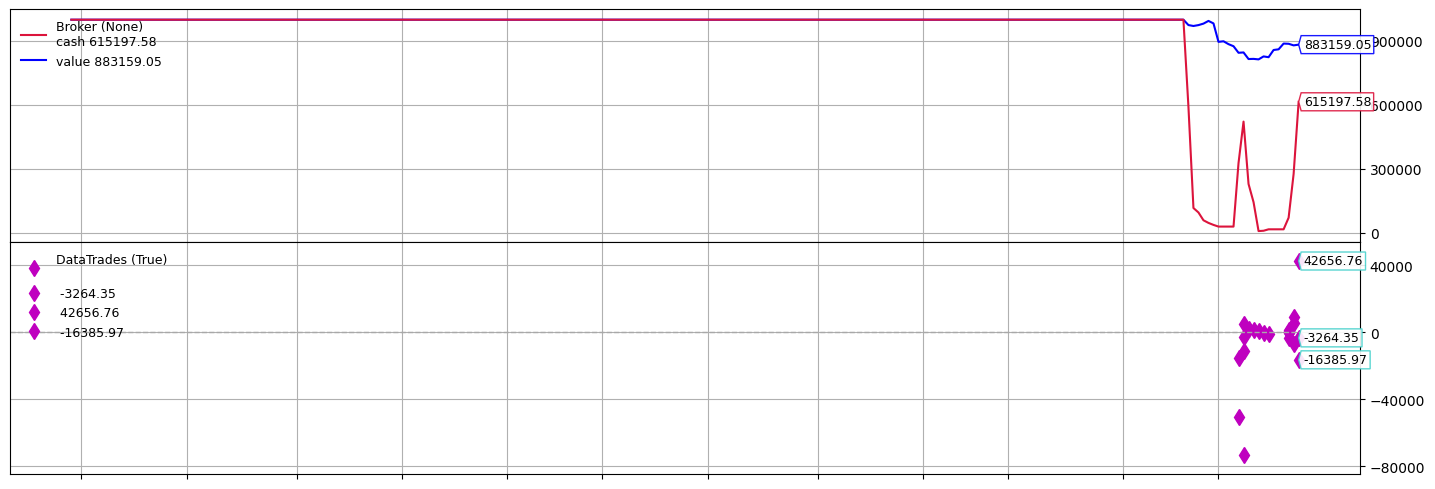

In [38]:

backtesting(backtest_list, start_date, end_date, init_cash, broker_com, MyStrategy)

# Part 6: Apply Deep Reinforcement Learning

In [39]:
## Deep Learning

# set the name of the directory
directory_name = 'tmp'

# create the directory if it does not exist
import os
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

# import yfinance
!pip install ta
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# Data Preprocessing
import pandas as pd
from pandas_datareader.data import DataReader
from ta.volume import VolumeWeightedAveragePrice

# Environment
import gym
from gym import spaces
import numpy as np
import random
import torch

# PyTorch
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

# Outputs
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 6.1 Data Preprocessing

In [40]:
backtest_list

[[59,
  [datetime.date(2022, 4, 26),
   datetime.date(2022, 5, 7),
   datetime.date(2022, 5, 13)]],
 [205, [datetime.date(2022, 5, 7)]],
 [343, [datetime.date(2022, 4, 22)]],
 [362, [datetime.date(2022, 5, 27)]],
 [471, [datetime.date(2022, 5, 27)]],
 [503, [datetime.date(2022, 4, 21)]],
 [572, [datetime.date(2022, 4, 22), datetime.date(2022, 5, 27)]],
 [616, [datetime.date(2022, 4, 21)]],
 [673, [datetime.date(2022, 5, 10)]],
 [690, [datetime.date(2022, 5, 27)]],
 [767, [datetime.date(2022, 5, 7)]],
 [894, [datetime.date(2022, 5, 16)]],
 [936, [datetime.date(2022, 5, 27)]],
 [948, [datetime.date(2022, 5, 11)]],
 [994, [datetime.date(2022, 5, 13)]],
 [1028, [datetime.date(2022, 5, 27)]],
 [1059, [datetime.date(2022, 5, 27)]],
 [1216, [datetime.date(2022, 5, 10)]],
 [1247, [datetime.date(2022, 5, 12)]],
 [1259, [datetime.date(2022, 5, 12)]],
 [1281, [datetime.date(2022, 4, 26)]],
 [1282, [datetime.date(2022, 5, 16)]],
 [1400, [datetime.date(2022, 5, 27)]],
 [1495, [datetime.date(2022, 4

In [41]:
# Data Extraction
stock_code = backtest_list[1][0]
symbol = str(backtest_list[1][0]).zfill(4)+".HK"
start_date = datetime.date(2022, 4, 20)
end_date = datetime.date(2022, 5, 27)
df = pdr.get_data_yahoo(symbol, start_date, end_date)
df.drop(columns=["Adj Close"], inplace=True)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2022-04-20,0.270,0.270,0.270,0.270,0
2022-04-21,0.250,0.300,0.250,0.290,495000
2022-04-22,0.290,0.290,0.290,0.290,0
2022-04-25,0.285,0.285,0.285,0.285,30000
2022-04-26,0.340,0.340,0.285,0.300,320000
2022-04-27,0.285,0.320,0.270,0.320,480750
2022-04-28,0.275,0.275,0.270,0.270,140000
2022-04-29,0.295,0.295,0.295,0.295,40000
2022-05-03,0.270,0.280,0.270,0.275,276250


In [42]:
# Process CCASS data
stock_ccass_df = ccass_df[ccass_df['stock_code']==stock_code]

stock_ccass_df = stock_ccass_df.drop_duplicates(subset = ['record_date','participant_name'])
screen_input = stock_ccass_df.pivot(index = 'record_date', columns = 'participant_name', values = 'percent').fillna(0)

screen_input.head(2)
  
broker_change = pd.DataFrame()
for column in screen_input.columns:
    broker_change['{}_change'.format(column)]= screen_input[column].diff().fillna(0)

cols_to_check = [broker_change.columns]

broker_change = broker_change[broker_change.columns[(broker_change!=0).any(axis=0)]].reset_index(drop = True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
broker_change

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ASTRUM CAPITAL MANAGEMENT LTD_change,BANK OF CHINA (HONG KONG) LTD_change,BNP PARIBAS_change,BOCI SECURITIES LTD_change,CITIBANK N.A._change,DBS BANK LTD_change,FUTU SECURITIES INTERNATIONAL_change,GET NICE SECURITIES LTD_change,GRANSING SECURITIES CO LTD_change,HANG SENG SECURITIES LTD_change,HING WAI ALLIED SECURITIES LTD_change,MERRILL LYNCH FAR EAST LTD_change,SHENWAN HONGYUAN SECURITIES (H.K.) LTD_change,SORRENTO SECURITIES LTD_change,STANDARD CHARTERED BANK (HONG KONG) LTD_change,ZHONGTAI INTERNATIONAL SECURITIES LTD_change
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,-0.0001,0.0000,-0.0004,0.0000,0.0000,0.0001,0.0000,0.0005,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,-0.0001,0.0000,-0.0001,0.0000,-0.0003,0.0000,0.0003
7,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0004,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,-0.0002,0.0000,0.0000
8,0.0001,0.0000,0.0000,0.0000,-0.0001,0.0000,0.0003,0.0000,0.0813,0.0000,0.0000,0.0000,0.0001,-0.0006,0.0000,0.0003
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [44]:
# Add VWAP to DataFrame
vwap = VolumeWeightedAveragePrice(high=df["High"], low=df["Low"], close=df["Close"], 
                                  volume=df["Volume"], window=2, fillna=False)
df["VWAP"] = vwap.volume_weighted_average_price()
df.fillna(0, inplace=True)
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Volume,VWAP
Date,,,,,,
2022-04-20,0.270,0.270,0.270,0.270,0,0.000000
2022-04-21,0.250,0.300,0.250,0.290,495000,0.280000
2022-04-22,0.290,0.290,0.290,0.290,0,0.280000
2022-04-25,0.285,0.285,0.285,0.285,30000,0.285000
2022-04-26,0.340,0.340,0.285,0.300,320000,0.306333
2022-04-27,0.285,0.320,0.270,0.320,480750,0.305331
2022-04-28,0.275,0.275,0.270,0.270,140000,0.296191
2022-04-29,0.295,0.295,0.295,0.295,40000,0.276852
2022-05-03,0.270,0.280,0.270,0.275,276250,0.277530


In [45]:
# Min Max Scaled
df_mod = df.copy()
df_mod = df_mod.pct_change() * 100


df_mod = (df_mod - df_mod.min()) / (df_mod.max() - df_mod.min())
df_mod = df_mod.fillna(0).iloc[1:]


df_mod = df_mod.reset_index(drop=True)
df_mod["Close_Price"] = df["Close"].iloc[1:].values
df_mod

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Volume,VWAP,Close_Price
0,0.247192,0.754588,0.251064,0.756654,0.0,0.0,0.290
1,0.907025,0.321610,1.000000,0.513308,0.0,0.0,0.290
2,0.407398,0.369847,0.432905,0.456667,0.0,0.0,0.285
3,1.000000,1.000000,0.488069,0.686212,0.0,0.0,0.300
4,0.000000,0.245203,0.319671,0.732319,0.0,0.0,0.320
5,0.357091,0.000000,0.488069,0.000000,0.0,0.0,0.270
6,0.661011,0.639531,0.784325,0.817490,0.0,0.0,0.295
7,0.217110,0.269111,0.216920,0.290585,0.0,0.0,0.275
8,0.560404,0.421528,0.488069,0.453578,0.0,0.0,0.270
9,0.355325,0.314474,0.488069,0.513308,0.0,0.0,0.270


In [46]:
# Split Training and Testing
df_train = df_mod.copy()
df_train = df_train.iloc[:len(df_mod)//2] #len(df_mod)//2
df_test = df_mod.copy()
df_test = df_test.iloc[len(df_mod)//2:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

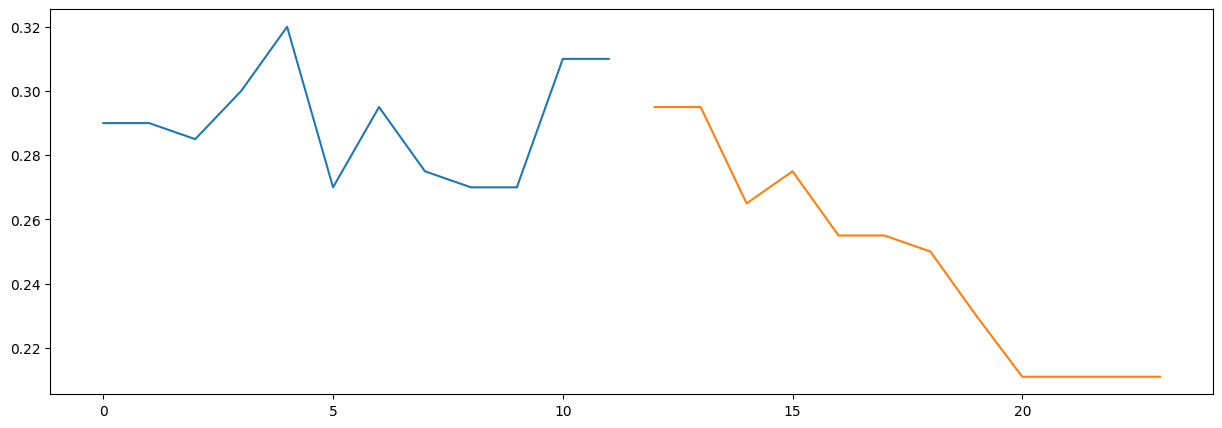

In [47]:
# View price behaviour
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
df_train["Close_Price"].plot()
df_test["Close_Price"].plot()

## 6.2 Environment

In [48]:
# Initialise variables
MAX_INT = 2147483647
MAX_TRADES = 10000
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4 # Threshold for balance preservation


# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, broker_change):
        super(StockTradingEnv, self).__init__()
        
        # Generic variables
        self.df = df
        self.broker_change = broker_change
        
        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        
        # Position variables
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0
        
        # Current Step
        self.current_step = 0
        self.lag = 1
        self.volatility = 1
        self.max_steps = len(broker_change)//2

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(2)

        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7+broker_change.shape[1], ), dtype=np.float32) #broker_change.shape[1]


    # Calculate Reward
    def _calculate_reward(self):
        reward = 0
        reward += self.net_profit / self.volatility
        reward += 0.01 if self.long_short_ratio >= 0.3 and self.long_short_ratio <= 0.6 else -0.01
        return reward
        
    # Structure sign observation data
    def _next_observation(self):
        
        item_0_T0 = self.df.loc[self.current_step - 0, "Open"].item()
        item_1_T0 = self.df.loc[self.current_step - 0, "High"].item()       
        item_2_T0 = self.df.loc[self.current_step - 0, "Low"].item()
        item_3_T0 = self.df.loc[self.current_step - 0, "Close"].item()
        item_4_T0 = self.df.loc[self.current_step - 0, "Volume"].item()
        item_5_T0 = self.df.loc[self.current_step - 0, "VWAP"].item()

        #item_6_T0= self.broker_change.loc[self.current_step - 0, "BANK OF CHINA (HONG KONG) LTD_change"].item()
        item_6_T0 =[]
        for col in broker_change.columns:
          item_6_T0.append(self.broker_change.loc[self.current_step - 0, col].item())
        
       
        env_4 = 1 if self.long_short_ratio else 0
        
        obs = np.concatenate((np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, env_4]),item_6_T0)) #item_6_T0
        
        return obs

    # Set the current price to a random price within the time step
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close_Price"].item()
        next_price = self.df.loc[self.current_step + 1, "Close_Price"].item()
        next_return = next_price / current_price - 1
        
        # Go Long
        if action == 0:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * next_return
            self.available_balance += self.net_profit
            self.num_trades_long += 1
                
        # Go Short
        if action == 1:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * -next_return
            self.available_balance += self.net_profit
            self.num_trades_short += 1
        
        # Update metrics
        self.long_short_ratio = self.num_trades_long / (self.num_trades_long + self.num_trades_short)
        self.volatility = self.df.loc[self.current_step - self.lag, "Close_Price"].sum()

    # Execute one time step within the environment
    def step(self, action):
        self._take_action(action)

        reward = self._calculate_reward()
    
        self.current_step += 1
        
        is_max_steps_taken = self.current_step >= self.max_steps - self.lag - 2
        done = True if is_max_steps_taken else False
        
        obs = self._next_observation()

        return obs, reward, done, {}

    # Reset the state of the environment to an initial state
    def reset(self):
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        self.current_step = self.lag
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.num_trades_ratio = 0

        return self._next_observation()

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# Test Environment
env = StockTradingEnv(df_train, broker_change)
actions = [0,1,2]
observation = env.reset()
print("Initial Observation: ", env.reset())

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Realized Profit: ", env.net_profit)
    print("Ratio: ", env.num_trades_ratio)
    print("-------------------")

Initial Observation:  [ 9.07025295e-01  3.21610216e-01  1.00000000e+00  5.13307963e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e-04  0.00000000e+00  0.00000000e+00
 -1.00000000e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]

Action Taken:  0
Reward Received :  -5.955297882728576
Next State:  [0.40739816 0.36984666 0.43290451 0.45666712 0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
Completed:  False
-------------------
Available Balance:  998.2758636636202
Realized Profit:  -1.7241363363798556
Ratio:  0
-------------------

Action Taken:  1
Reward Received :  -24.052846635565437
Next State:  [ 1.00000000e+00  1.00000000e+00  4.88069405e-01  6.86211937e-01
  0.00000000e+00  0.0

In [50]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [51]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo') #Original V1 has some awesome weights
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [52]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [53]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            # Calculate the advantage
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [54]:
# Testing

env = StockTradingEnv(df_train, broker_change)

batch_size = 5
n_epochs = 4
alpha = 0.0003

agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                alpha=alpha, n_epochs=n_epochs, 
                input_dims=env.observation_space.shape)

observation = env.reset()
action, prob, val = agent.choose_action(observation)
n_actions = env.action_space.n
print("Oberservation: ", observation)
print("Number of Actions: ", n_actions)
print("Action Chosen: ", action)
print("Probability of Action: ", prob)
print("Value of Action: ", val)

observation_, reward, done, info = env.step(action)
print("Next Oberservation", observation_)
print("Reward", reward)
print("Done", done)
print("Info", info)

Oberservation:  [ 9.07025295e-01  3.21610216e-01  1.00000000e+00  5.13307963e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e-04  0.00000000e+00  0.00000000e+00
 -1.00000000e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Number of Actions:  2
Action Chosen:  1
Probability of Action:  -0.7165713310241699
Value of Action:  -0.0773094892501831
Next Oberservation [0.40739816 0.36984666 0.43290451 0.45666712 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
Reward 5.935297882728577
Done False
Info {}


... starting ...
... saving models ...
episide: 0, score: 164.26577514461334, avg score: 164.26577514461334, best_score: 164.26577514461334
episide: 1, score: 34.125758188245385, avg score: 99.19576666642936, best_score: 164.26577514461334
episide: 2, score: 164.26577514461334, avg score: 120.88576949249068, best_score: 164.26577514461334
episide: 3, score: -104.96802410738957, avg score: 64.42232109252062, best_score: 164.26577514461334
episide: 4, score: 20.40649179969537, avg score: 55.61915523395557, best_score: 164.26577514461334
episide: 5, score: -179.86246792563838, avg score: 16.372218040689905, best_score: 164.26577514461334
episide: 6, score: 96.16826439023542, avg score: 27.771653233482123, best_score: 164.26577514461334
episide: 7, score: -97.7582860790547, avg score: 12.080410819415029, best_score: 164.26577514461334
episide: 8, score: 180.03574695136234, avg score: 30.742114834075842, best_score: 164.26577514461334
episide: 9, score: 240.087207136199, avg score: 51.67662

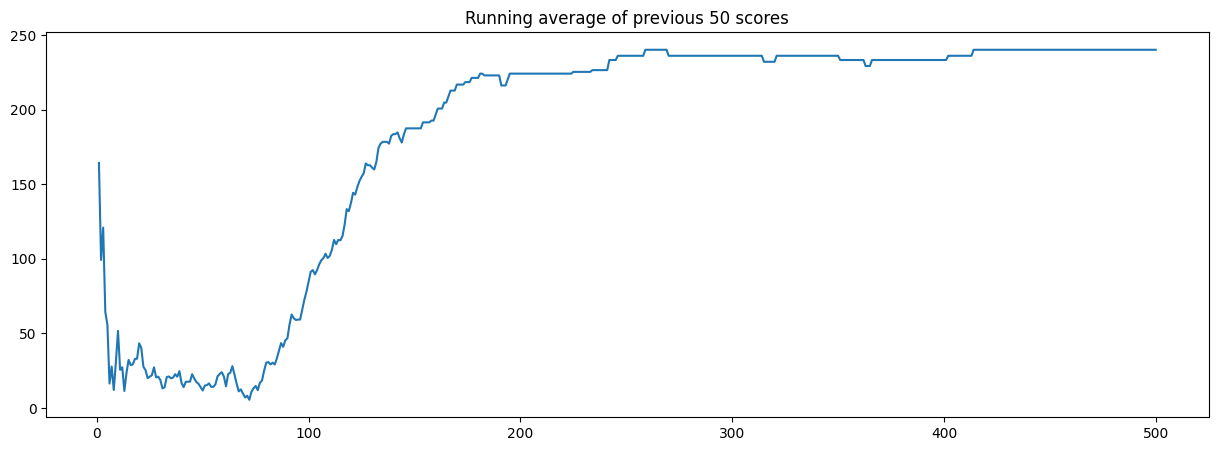

In [55]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 50 scores')
    plt.savefig(figure_file)

if __name__ == '__main__':
    env = StockTradingEnv(df_train, broker_change)
    N = 20
    batch_size = 5
    n_epochs = 3
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape)

    n_games = 500

    figure_file = 'stock_training.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0
    
    print("... starting ...")
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
            observation = observation_
            
        # Save history
        score_history.append(score)
        avg_score = np.mean(score_history[-50:])
        
        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()
        
        print(f"episide: {i}, score: {score}, avg score: {avg_score}, best_score: {best_score}")
            
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

## 6.3 Load Model

In [56]:
# agent.save_models()
n_actions = env.action_space.n
input_dims = env.observation_space.shape
alpha = 0.0003
model = ActorNetwork(n_actions, input_dims, alpha)
model.load_state_dict(T.load("tmp/actor_torch_ppo"))
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=23, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

In [57]:
reporting_df = df_test.copy()
long_probs = []
short_probs = []
is_long = 1
is_short = 1
long_ratio = 0.5
for step in range(0, len(reporting_df)): #should change 0 to 5 if we have enough data

    item_0_T0 = df_mod.loc[step - 0, "Open"].item()
    item_1_T0 = df_mod.loc[step - 0, "High"].item()
    item_2_T0 = df_mod.loc[step - 0, "Low"].item()
    item_3_T0 = df_mod.loc[step - 0, "Close"].item()
    item_4_T0 = df_mod.loc[step - 0, "Volume"].item()
    item_5_T0 = df_mod.loc[step - 0, "VWAP"].item()
    item_6_T0 =[]
    for col in broker_change.columns:
      item_6_T0.append(broker_change.loc[step - 0, col].item())
    
    obs = np.concatenate((np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, long_ratio]), item_6_T0))


    
    state = T.tensor(obs).float()
    dist = model(state)
    probs = dist.probs.detach().numpy()
    
    print(np.argmax(probs), probs)
    
    if action == 0:
        is_long += 1
    if action == 0:
        is_short += 1
    long_ratio = is_long / (is_long + is_short)

    long_probs.append(probs[0])
    short_probs.append(probs[1])

0 [0.9721468  0.02785317]
0 [9.9961549e-01 3.8451876e-04]
0 [0.99209046 0.00790954]
0 [9.9990028e-01 9.9743535e-05]
1 [0.13363193 0.86636806]
0 [0.99457633 0.0054237 ]
0 [0.99818265 0.0018173 ]
0 [0.9757832  0.02421679]
0 [0.99751264 0.00248738]
0 [0.9836346  0.01636541]
0 [0.99657744 0.00342255]
0 [9.992511e-01 7.488692e-04]


In [58]:
reporting_df

,Open,High,Low,Close,Volume,VWAP,Close_Price
12,0.456000,0.421528,0.333251,0.354348,0.0,0.0,0.295
13,0.319601,0.276486,0.488069,0.513308,0.0,0.0,0.295
14,0.264888,0.218306,0.000000,0.179223,0.0,0.0,0.265
15,0.507253,0.476029,0.552061,0.637277,0.0,0.0,0.275
16,0.355325,0.153891,0.488069,0.274386,0.0,0.0,0.255
17,0.299394,0.421528,0.488069,0.513308,0.0,0.0,0.255
18,0.456000,0.539079,0.425333,0.448893,0.0,0.0,0.250
19,0.400727,0.251857,0.232104,0.250494,0.0,0.0,0.230
20,0.174109,0.121775,0.209846,0.241924,0.0,0.0,0.211
21,0.280601,0.235015,0.503305,0.513308,0.0,0.0,0.211


In [59]:
capital = 1
perc_invest = 1
df_res = reporting_df.copy()
df_res = df_res[["Open", "Close_Price"]]
df_res["Returns"] = df_res["Close_Price"] / df_res["Close_Price"].shift(1) - 1
df_res = df_res.iloc[0:, :]
df_res["Longs"] = long_probs
df_res["Shorts"] = short_probs
df_res.loc[df_res["Longs"] >= 0.5, "DIR"] = df_res["Longs"]
df_res.loc[df_res["Longs"] < 0.5, "DIR"] = -df_res["Shorts"]
df_res = df_res.reset_index(drop=True)

equity = capital
equities = [capital]
for index, row in df_res.iterrows():
    if index > 0:
        dir_value = df_res.loc[index - 1, "DIR"].item()
        ret_value = df_res.loc[index, "Returns"].item()
        equity = equities[index - 1] + equities[index - 1] * perc_invest * dir_value * ret_value
        equities.append(equity)
        
df_res["Equity"] = equities
df_res["Benchmark"] = df_res["Returns"].cumsum() + 1
df_res.head()
df_res

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,Close_Price,Returns,Longs,Shorts,DIR,Equity,Benchmark
0,0.456000,0.295,NaN,0.972147,0.027853,0.972147,1.000000,NaN
1,0.319601,0.295,0.000000,0.999615,0.000385,0.999615,1.000000,1.000000
2,0.264888,0.265,-0.101695,0.992090,0.007910,0.992090,0.898344,0.898305
3,0.507253,0.275,0.037736,0.999900,0.000100,0.999900,0.931976,0.936041
4,0.355325,0.255,-0.072727,0.133632,0.866368,-0.866368,0.864203,0.863314
5,0.299394,0.255,0.000000,0.994576,0.005424,0.994576,0.864203,0.863314
6,0.456000,0.250,-0.019608,0.998183,0.001817,0.998183,0.847349,0.843706
7,0.400727,0.230,-0.080000,0.975783,0.024217,0.975783,0.779685,0.763706
8,0.174109,0.211,-0.082609,0.997513,0.002487,0.997513,0.716836,0.681097
9,0.280601,0.211,0.000000,0.983635,0.016365,0.983635,0.716836,0.681097


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

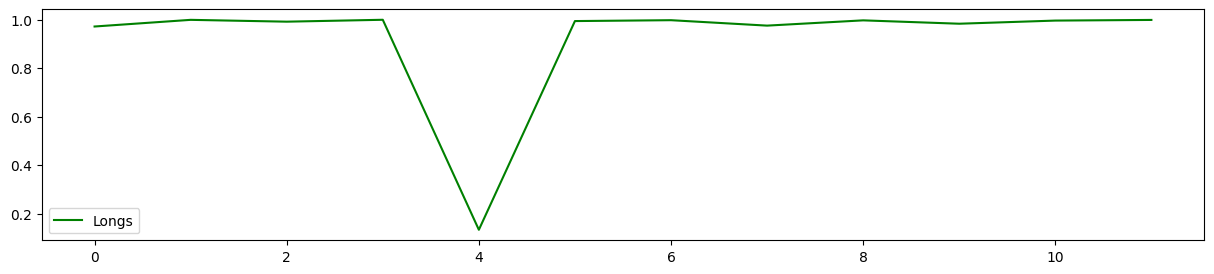

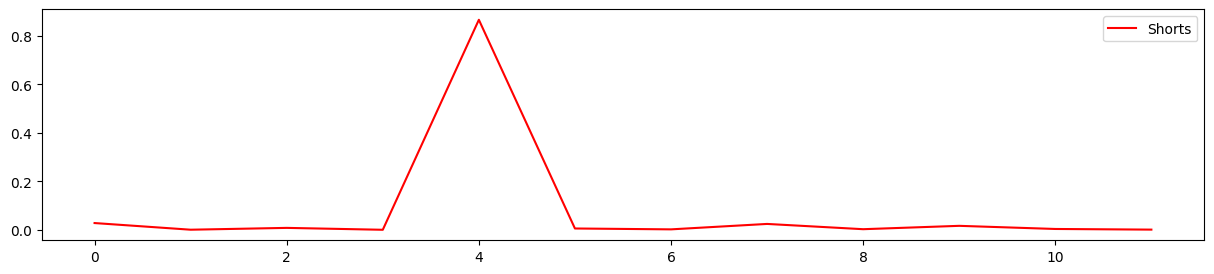

In [60]:
plt.rcParams["figure.figsize"] = (15,3)
df_res[["Longs"]].plot(color="green")
df_res[["Shorts"]].plot(color="red")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

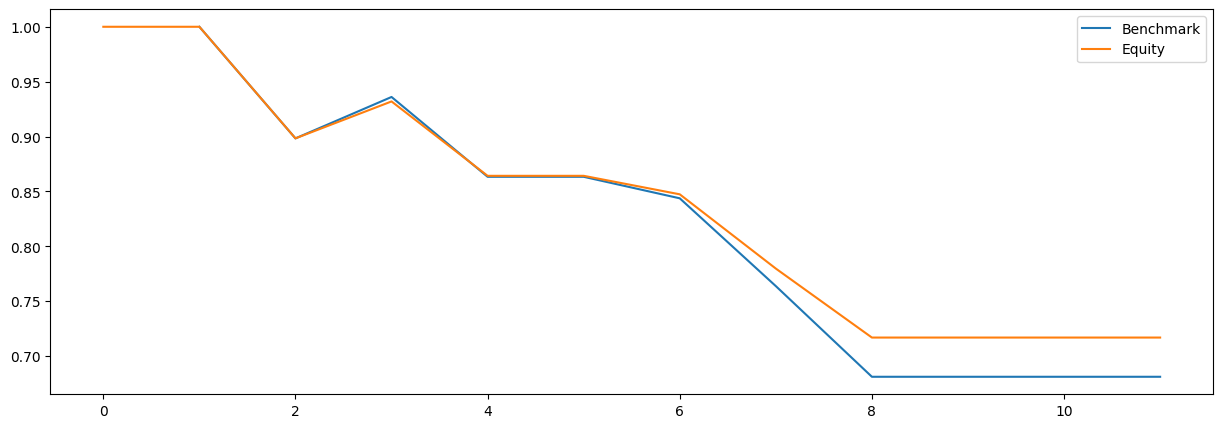

In [61]:
plt.rcParams["figure.figsize"] = (15,5)
df_res[["Benchmark", "Equity"]].plot()

In [62]:
# Metrics
Benchmark_Perc = (df_res["Close_Price"].iloc[-1] / df_res["Close_Price"].iloc[0] - 1) * 100
ROI_Perc = (df_res["Equity"].iloc[-1] / capital - 1) * 100
print(f"Benchmark Return {round(Benchmark_Perc, 2)}%")
print(f"ROI at {round(ROI_Perc, 2)}%")

Benchmark Return -28.47%
ROI at -28.32%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
